### Authors
- Gabriel Souza Lima
- Guilherme Mertens
- Kiyoshi Araki
- Lucas Tramonte

# Task 4 — Extra Experiment: Generalization to Different Lane Counts

Goal : Explore whether a DQN agent trained on a 4-lane highway generalizes well to different highway configurations with **2, 3, and 5 lanes**.

###  Hypothesis

A DQN agent trained on a 4-lane highway will perform worse on environments with different lane counts due to increased complexity or different traffic dynamics.

### Setup

We will:
- Load the configuration from `config.pkl`
- Evaluate the agent on environments with 2, 3, 4, and 5 lanes
- Compare total rewards


### 1. Import dependencies

In [9]:
import gymnasium as gym
import highway_env
import pickle
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

###  2. Load configuration and prepare environment

In [12]:
# Load the config used during training
with open("config.pkl", "rb") as f:
    config = pickle.load(f)

# Create and configure the environment
env = gym.make("highway-fast-v0")
env.unwrapped.configure(config)

# Get the observation space shape dynamically
obs_sample, _ = env.reset()
obs_shape = obs_sample.shape
n_actions = env.action_space.n


###  Define the DQN Model

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        flat_dim = int(np.prod(input_shape))
        self.fc = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)

###  Load the Trained Model from task 1


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = DQN(obs_shape, n_actions).to(device)
policy_net.load_state_dict(torch.load("trained_dqn_agent.pth", map_location=device))
policy_net.eval()


DQN(
  (fc): Sequential(
    (0): Linear(in_features=448, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=5, bias=True)
  )
)

###  Evaluation Function

This function tests the trained agent on a highway environment with a given number of lanes and returns total rewards over multiple episodes.


In [14]:
def evaluate_on_lanes(n_lanes, episodes=5):
    # Load base config
    with open("config.pkl", "rb") as f:
        base_config = pickle.load(f)

    config = base_config.copy()
    config["lanes_count"] = n_lanes

    env = gym.make("highway-fast-v0", render_mode="rgb_array")
    env.unwrapped.configure(config)

    episode_rewards = []

    for _ in range(episodes):
        obs, _ = env.reset()
        total_reward = 0
        for _ in range(400):
            state_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                action = policy_net(state_tensor).argmax().item()
            obs, reward, done, truncated, _ = env.step(action)
            total_reward += reward
            if done or truncated:
                break
        episode_rewards.append(total_reward)

    env.close()
    return episode_rewards


In [15]:
lane_variants = [2, 3, 4, 5]
results = {}

for lanes in lane_variants:
    rewards = evaluate_on_lanes(lanes)
    results[lanes] = rewards
    print(f"{lanes} lanes → Avg Reward: {np.mean(rewards):.2f}, Std: {np.std(rewards):.2f}")


2 lanes → Avg Reward: 34.25, Std: 18.21
3 lanes → Avg Reward: 41.63, Std: 4.29
4 lanes → Avg Reward: 45.88, Std: 4.72
5 lanes → Avg Reward: 46.99, Std: 5.93


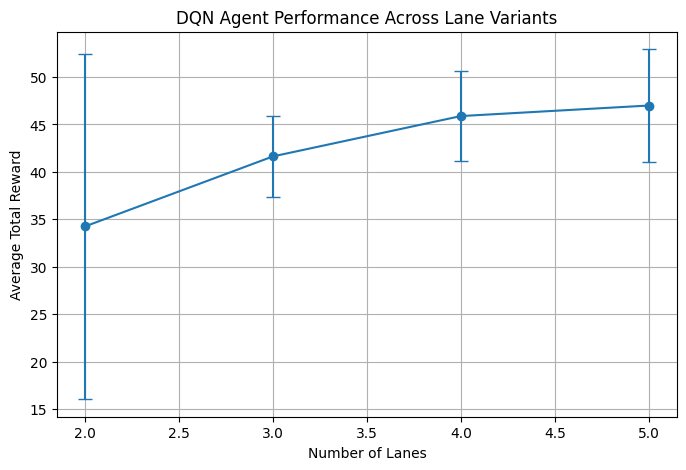

In [16]:
means = [np.mean(results[lanes]) for lanes in lane_variants]
stds = [np.std(results[lanes]) for lanes in lane_variants]

plt.figure(figsize=(8, 5))
plt.errorbar(lane_variants, means, yerr=stds, fmt='-o', capsize=5)
plt.xlabel("Number of Lanes")
plt.ylabel("Average Total Reward")
plt.title("DQN Agent Performance Across Lane Variants")
plt.grid(True)
plt.show()


- Performance Trend:
There's a clear positive correlation between the number of lanes and the average total reward.

The DQN agent performs progressively better as more lanes are added, suggesting the agent benefits from increased flexibility or maneuverability.

- Performance Plateau:
The largest jump occurs from 2 to 3 lanes (+7.38 reward).

Gains diminish as the number of lanes increases further:

+4.25 (from 3 → 4 lanes)

+1.11 (from 4 → 5 lanes)

This indicates a performance plateau beyond 4 lanes — adding more lanes yields diminishing returns.

-  Stability:
Highest variability (std: 18.21) is at 2 lanes, suggesting unstable behavior or harder learning due to restricted space.

From 3 lanes onward, the standard deviation drops sharply and stays low (around 4–6), implying:

    - More consistent decision-making.

    - Better generalization across episodes.


With only 2 lanes, the agent likely has fewer options to avoid collisions or make strategic lane changes, leading to erratic performance.

More lanes provide more strategic depth and room for the agent to execute learned policies effectively